In [ ]:
!pip install -q transformers datasets librosa

!pip install nltk pymorphy2 spacy stopwords
!python -m spacy download ru_core_news_sm

In [1]:
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import os
import re
import random
import itertools
from collections import defaultdict
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt


import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import pymorphy2

In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [3]:
data_train = pd.read_csv("data_train_final.csv")
data_val = pd.read_csv("valid.csv")

df_merged = pd.concat([data_train, data_val])
print(df_merged.shape)

from sklearn.model_selection import train_test_split
train, val = train_test_split(df_merged, test_size = 0.2, random_state=42)

train.to_csv('data_train_final_v2.csv', index=False)
val.to_csv('valid_v2.csv', index=False)

(63630, 8)


#### 🌀 Загружаем данные (предварительно загрузите их с диска в Google Colab)

[Ссылка на данные](https://disk.yandex.ru/d/awG8jCY01BGcAQ)

In [4]:
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

data = load_dataset("csv", data_files={"train": "data_train_final_v2.csv", "validation": "valid_v2.csv"})
data

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 50904
    })
    validation: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 12726
    })
})

#### 🔎 Выведем уникальные символы в сплитах

In [5]:
def get_alphabet(data_split):
    alphabet = set()
    for sample in data_split:
        uniq_chars = set(sample["text"])
        alphabet.update(uniq_chars)
    return alphabet

print("Train unique symbols: ", get_alphabet(data["train"]))
print("Valid unique symbols: ", get_alphabet(data["validation"]))

Train unique symbols:  {'Б', '⢤', '≠', '⛑', 'j', '4', '🙄', '‽', '⡟', '😘', '⚰', '☺', '➡', '🙌', '👊', '😗', '⣹', 'ф', '¯', '👌', '･', '💲', '♂', '🏽', 'ю', '💭', '😁', '😀', 'a', '😓', 'Ò', '😪', '무', 'х', '😍', '🎂', '👍', 'Е', '👴', '.', '😞', 'c', 'З', 'Я', '√', 'ň', '👓', '`', 'в', '☹', '雅', 'i', '😤', 'ќ', 'F', 'и', 'p', '⣶', 'е', '”', '⢧', 'л', '🤪', '❣', '😒', '⠇', 'X', '🙁', '⣆', '⡷', '💚', '🌿', 'н', 'u', '🎖', '😣', 'ы', '😰', '⠛', '—', '|', '⠞', '&', '🗑', 'К', '⣠', 'w', '0', '[', 'ω', '😠', '🤭', 'Ы', '✨', '🍺', '⛏', '-', 'э', 'm', '?', '⢣', '면', '🇫', '©', '玛', '😄', '🏻', 'б', '👑', '💩', '⢀', '"', '🥕', '⣼', '💖', '⠘', '🇦', 'а', '😾', 'О', 'f', '🅱', 'у', '🤰', '😖', '💦', '😬', '–', 'A', '👎', 'к', '😔', '🐢', '~', ')', 'U', '😿', '💔', 'з', '🎣', 'C', '📚', 'д', 'r', '😥', ',', '☕', '7', 'г', '🍻', '니', '⠉', '🤤', 'W', '😩', '🖐', 'n', '⣄', '🙋', 'ш', '中', '인', '▪', 'e', 'D', '😛', '\u200b', 'V', '♥', 'Т', '1', 'В', 'é', '⠹', 'M', 'С', 'k', '️', '$', 'P', '🤜', 'ъ', '🤷', '🇺', 'N', '⣇', '!', '⠴', '⡏', '9', '3', '카', 'ч', '🤨', '

#### 📊 Построим гистограммы распределения

In [6]:
def plot_histogram(data_split):
    class_counts = {
        'anger': 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0,
        'sadness': 0,
        'surprise': 0,
        'neutral': 0
    }

    for sample in data_split:
        for emotion in labels:
            class_counts[emotion] += sample[emotion]

    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Классы эмоций')
    plt.ylabel('Количество')
    plt.title('Распределение по классам эмоций')
    plt.xticks(rotation=45)

    plt.show()

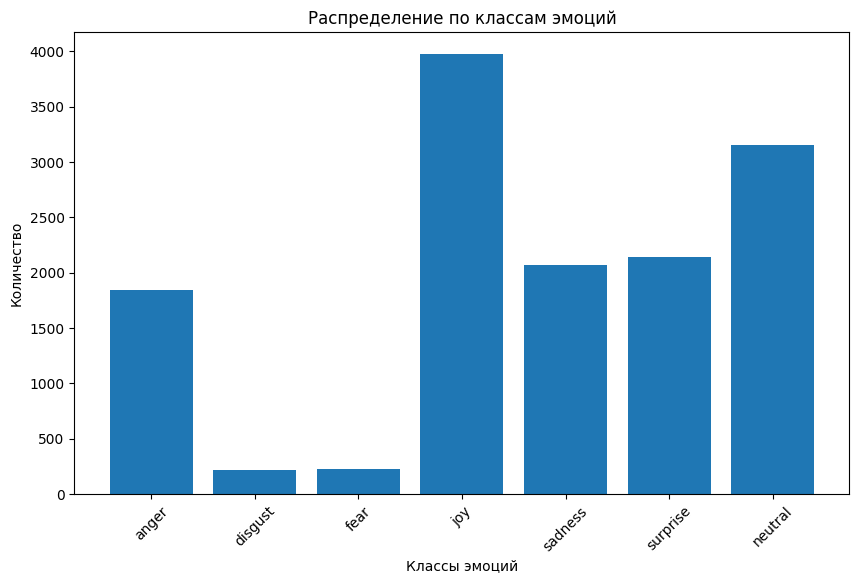

In [7]:
plot_histogram(data["validation"])

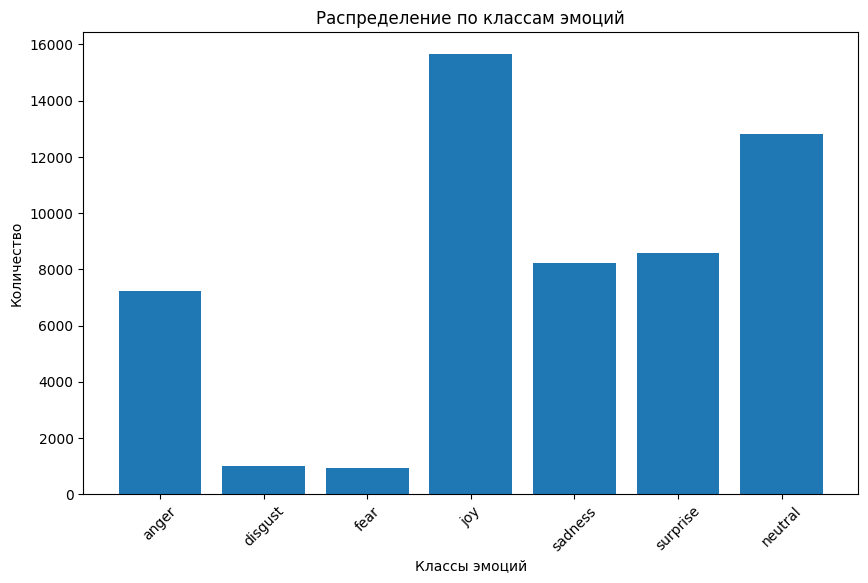

In [8]:
plot_histogram(data["train"])

In [9]:
def plot_combined_emotions(data_split):
    emotion_pairs = defaultdict(int)

    for entry in data_split:
        emotions = {key: value for key, value in entry.items() if key in labels}
        active_emotions = [emotion for emotion, value in emotions.items() if value > 0]

        for pair in itertools.combinations(sorted(active_emotions), 2):
            emotion_pairs[pair] += 1

    sorted_pairs = sorted(emotion_pairs.items(), key=lambda x: x[1], reverse=True)
    pairs = [f"{pair[0]} & {pair[1]}" for pair, _ in sorted_pairs]
    counts = [count for _, count in sorted_pairs]

    plt.figure(figsize=(12, 6))
    plt.bar(pairs, counts)
    plt.xlabel('Пары эмоций')
    plt.ylabel('Количество')
    plt.title('Совместное появление эмоций')
    plt.xticks(rotation=45)

    plt.show()

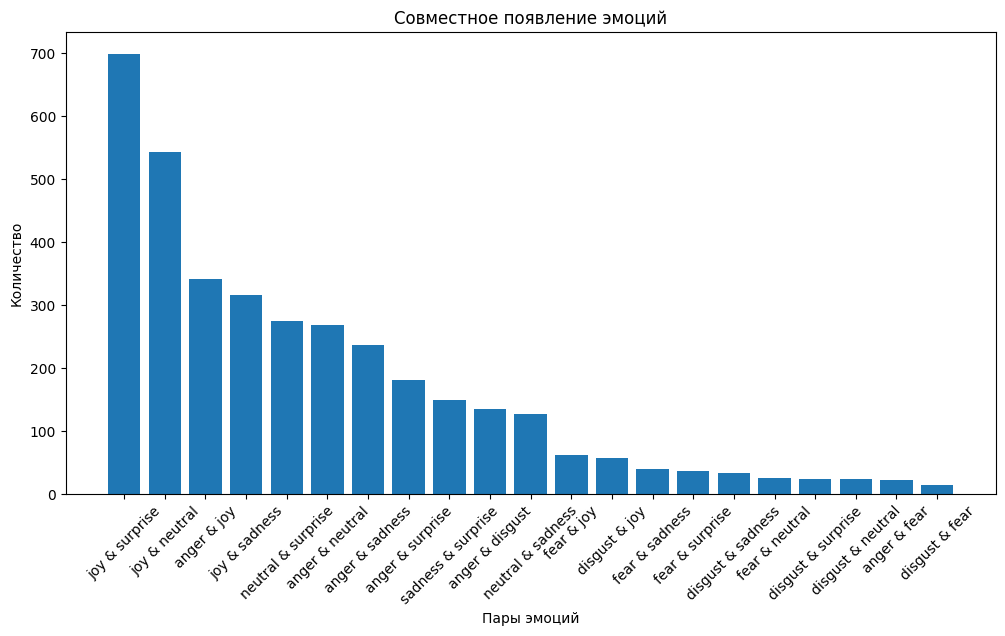

In [10]:
plot_combined_emotions(data["train"])

#### 🧹 Приведем тексты к нижнему регистру и удалим лишние знаки

In [11]:
# Загрузка необходимых ресурсов
nltk.download('stopwords')

# Загрузка русского языка для spaCy
nlp = spacy.load('ru_core_news_sm')

# Стоп-слова на русском
stop_words = set(stopwords.words('russian'))

# Инициализация лемматизатора pymorphy2
morph = pymorphy2.MorphAnalyzer()


def cleaner(example):
    example["text"] = example["text"].lower()
    example["text"] = re.sub(r"[^a-zа-я\d]", " ", example["text"])
    example["text"] = re.sub(r"\s+", " ", example["text"])
    example["text"] = example["text"].strip()
    # проверка на стоп-слова и лемматизация
    example["text"] = ' '.join([morph.normal_forms(word)[0] for word in example["text"].split(' ') if word not in stop_words])

    return example

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
data = data.map(cleaner)

Map:   0%|          | 0/50904 [00:00<?, ? examples/s]

Map:   0%|          | 0/12726 [00:00<?, ? examples/s]

In [13]:
data['train'][0]['text']

'отличный работа давать получить очко'

#### 🏋️ Подготовим модель

In [14]:
class Model(torch.nn.Module):
    def __init__(self, pretrained_model, hidden_dim, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model)
        self.fc = torch.nn.Linear(hidden_dim, num_classes)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.fc(features)
        return output


# model_name = 'ai-forever/ruBert-base'
# hidden_dim = 768

# model_name = 'ai-forever/ruBert-large'
# hidden_dim = 1024

model_name = 'ai-forever/ruRoberta-large'
hidden_dim = 1024

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(pretrained_model=model_name, hidden_dim=hidden_dim, num_classes=len(labels))
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 📒 Подготовим данные для обучения

In [15]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_len = 32
batch_size = 64

data = data.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length",
                                           return_token_type_ids=True), batched=True)

Map:   0%|          | 0/50904 [00:00<?, ? examples/s]

Map:   0%|          | 0/12726 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [16]:
def one_hot_to_list(example):
    emotions = []
    for emotion in labels:
        emotions.append(example[emotion])
    example["one_hot_labels"] = emotions

    return example

data = data.map(one_hot_to_list)
data["train"][9]["one_hot_labels"]

Map:   0%|          | 0/50904 [00:00<?, ? examples/s]

Map:   0%|          | 0/12726 [00:00<?, ? examples/s]

[0, 0, 0, 0, 0, 1, 0]

#### 🔗 Dataset & DataLoader

In [17]:
class EmotionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return {
            'input_ids': torch.tensor(self.dataset[index]["input_ids"], dtype=torch.long),
            'attention_mask': torch.tensor(self.dataset[index]["attention_mask"], dtype=torch.long),
            'token_type_ids': torch.tensor(self.dataset[index]["token_type_ids"], dtype=torch.long),
            'labels': torch.tensor(self.dataset[index]["one_hot_labels"], dtype=torch.float)
        }

In [18]:
train_dataset = EmotionDataset(data["train"])
valid_dataset = EmotionDataset(data["validation"])

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#### 🚀 Инициализируем функцию ошибки и оптимизатор

In [20]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00001, weight_decay=0.)

#### 🥷 Код для обучения и валидации

In [21]:
def train(model, criterion, optimizer, dataloader):
    train_loss = 0.0
    model.train()
    for idx, data in enumerate(dataloader):
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        labels = data["labels"].to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = criterion(outputs, labels)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Train loss: {train_loss / len(dataloader)}')

    return model

In [22]:
def validation(model, criterion, dataloader):
    val_loss = 0.0
    model.eval()
    val_targets, val_outputs = [], []
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
            labels = data["labels"].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            val_targets.extend(labels.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    print(f'Valid loss: {val_loss / len(dataloader)}')

    return val_outputs, val_targets

#### 🏃‍♂️‍➡️ Запускаем обучение

In [23]:
epochs = 4

for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    model = train(model, criterion, optimizer, train_dataloader)
    val_outputs, val_targets = validation(model, criterion, valid_dataloader)

Epoch: 0
Train loss: 0.3028518673425643
Valid loss: 0.2675622867130155
Epoch: 1
Train loss: 0.26342046861747404
Valid loss: 0.2618047190670991
Epoch: 2
Train loss: 0.244451724516986
Valid loss: 0.2709132411222362
Epoch: 3
Train loss: 0.22381866053121174
Valid loss: 0.2673072133531523


In [24]:
outputs, targets = validation(model, criterion, valid_dataloader)
outputs = np.array(outputs) >= 0.5
print(metrics.classification_report(targets, outputs, target_names=labels))

Valid loss: 0.2673072133531523
              precision    recall  f1-score   support

       anger       0.60      0.41      0.49      1844
     disgust       0.46      0.32      0.37       222
        fear       0.72      0.39      0.51       229
         joy       0.77      0.75      0.76      3974
     sadness       0.71      0.64      0.67      2071
    surprise       0.59      0.35      0.44      2146
     neutral       0.56      0.47      0.51      3154

   micro avg       0.67      0.54      0.60     13640
   macro avg       0.63      0.47      0.53     13640
weighted avg       0.65      0.54      0.59     13640
 samples avg       0.57      0.56      0.56     13640



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### ✏️ Получаем результаты на тесте

In [25]:
test = load_dataset("csv", data_files={"test": "test_without_answers.csv"})

Generating test split: 0 examples [00:00, ? examples/s]

In [26]:
test = test.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length",
                                           return_token_type_ids=True), batched=True)

test = test.map(one_hot_to_list)
test = test.map(cleaner)

Map:   0%|          | 0/8742 [00:00<?, ? examples/s]

Map:   0%|          | 0/8742 [00:00<?, ? examples/s]

Map:   0%|          | 0/8742 [00:00<?, ? examples/s]

In [27]:
test_dataset = EmotionDataset(test["test"])
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [28]:
outputs, _ = validation(model, criterion, test_dataloader)
outputs = np.array(outputs) >= 0.5

Valid loss: 0.28240145416983586


#### 🧑‍🍳 Готовим сабмит

In [29]:
import pandas as pd

df = pd.read_csv("test_without_answers.csv")

Изначально все метки классов инициализированы нулями, нужно их заполнить результатами модели.

In [30]:
df.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral
0,надеюсь вы сохранили это письмо,0,0,0,0,0,0,0
1,я зашел в ваш профиль чтобы посмотреть другие ...,0,0,0,0,0,0,0
2,ты реально пустое место,0,0,0,0,0,0,0
3,я не могу сказать счастливый это конец или гру...,0,0,0,0,0,0,0
4,это 8 раундов по разным темам организованных п...,0,0,0,0,0,0,0


In [31]:
df[labels] = outputs.astype(int)

In [32]:
df.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral
0,надеюсь вы сохранили это письмо,0,0,0,1,0,0,0
1,я зашел в ваш профиль чтобы посмотреть другие ...,0,0,0,1,0,0,0
2,ты реально пустое место,1,0,0,0,0,0,0
3,я не могу сказать счастливый это конец или гру...,0,0,0,0,1,0,0
4,это 8 раундов по разным темам организованных п...,0,0,0,0,0,0,1


In [33]:
df.index.name = 'id'
df.index += 1
dfdf = df[['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']]
dfdf.to_csv("submission_augmentation_lemma.csv", index=True)

In [34]:
df_sub = pd.read_csv("submission_augmentation_lemma.csv")
df_sub

,id,anger,disgust,fear,joy,sadness,surprise,neutral
0,1,0,0,0,1,0,0,0
1,2,0,0,0,1,0,0,0
2,3,1,0,0,0,0,0,0
3,4,0,0,0,0,1,0,0
4,5,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
8737,8738,0,0,0,0,1,0,0
8738,8739,0,0,0,0,0,0,1
8739,8740,0,0,0,1,0,0,0
8740,8741,0,0,0,0,0,0,1
